# Crecimiento salarial vs salarios

Lucho Sep-2023

#Pasos para crear un modelo VAR con series temporales multivariantes:

1. Análisis exploratorios de los datos.
2. Dividir la serie en conjuntos de entrenamiento y prueba.
3. Prueba de estacionariedad.
4. Transformar la serie de entrenamiento si es necesario. 
5. Construir un modelo VAR sobre las series transformadas.
6. Causalidad de Granger.
7. Diagnóstico del modelo.
8. Realizar pronósticos utilizando el modelo finalmente elegido.
9. Transformación inversa del pronóstico a la escala original.
10. Realizar una evaluación del pronóstico.

# Los datos: 

Conjunto de datos de serie de tiempo utilizada en el artículo de 1994 de Yash P Mehra: "Crecimiento salarial y el proceso de inflación: un enfoque empírico".

Este conjunto de datos tiene varias series de tiempo trimestrales y se puede descargar en:

https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv

# Import Librarys

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.graphics.tsaplots as sgt

#### Import dataset

In [56]:
filepath = 'https://raw.githubusercontent.com/selva86/datasets/master/Raotbl6.csv'
df_comp = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
print(df_comp.shape)  # (123, 8)
df_comp.tail()

(123, 8)


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0
1989-04-01,4132.5,4044.1,186.1,134.8,129.3,111.1,129.0,100.6
1989-07-01,4162.9,4068.4,187.4,137.2,130.2,109.8,129.9,98.2


In [57]:
df_comp.isnull().sum()

rgnp     0
pgnp     0
ulc      0
gdfco    0
gdf      0
gdfim    0
gdfcf    0
gdfce    0
dtype: int64

In [58]:
df_comp.isna().sum()

rgnp     0
pgnp     0
ulc      0
gdfco    0
gdf      0
gdfim    0
gdfcf    0
gdfce    0
dtype: int64

# Analisis Exploratorio de datos (EDA)

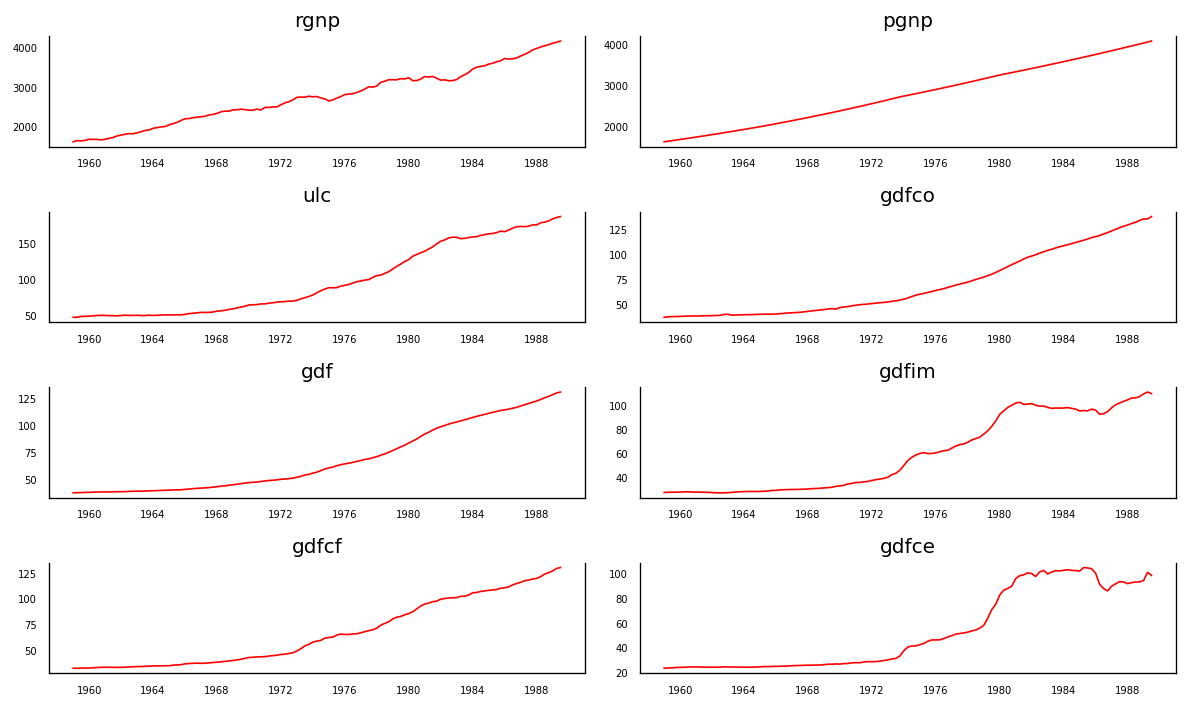

In [59]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_comp[df_comp.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_comp.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Cada una de las series tiene patrones de tendencia bastante similares a lo largo de los años, excepto gdfce y gdfim, donde se observa un patrón diferente a partir de 1980.

In [60]:
corr=df_comp.corr()
corr

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
rgnp,1.000000,0.991835,0.950064,0.951206,0.951956,0.931911,0.960079,0.887527
pgnp,0.991835,1.000000,0.969661,0.961704,0.965540,0.959446,0.975387,0.921616
ulc,0.950064,0.969661,1.000000,0.994035,0.997374,0.982889,0.997970,0.976054
gdfco,0.951206,0.961704,0.994035,1.000000,0.999118,0.962256,0.994390,0.954946
gdf,0.951956,0.965540,0.997374,0.999118,1.000000,0.970542,0.996960,0.964980
gdfim,0.931911,0.959446,0.982889,0.962256,0.970542,1.000000,0.982991,0.979462
gdfcf,0.960079,0.975387,0.997970,0.994390,0.996960,0.982991,1.000000,0.966780
gdfce,0.887527,0.921616,0.976054,0.954946,0.964980,0.979462,0.966780,1.000000


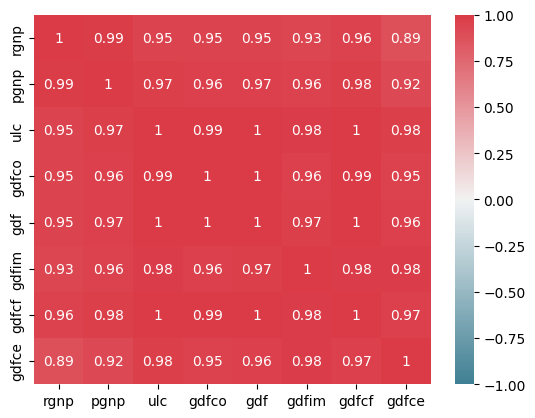

In [61]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sns.diverging_palette(220, 10, as_cmap=True),center=0 )
plt.show()

# Dividir los datos en conjunto de Entrenamiento y Prueba
El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

In [62]:
n_obs=15
X_train, X_test = df_comp[0:-n_obs], df_comp[-n_obs:]
print(X_train.shape, X_test.shape)

(108, 8) (15, 8)


# Prueba de estacionariedad
Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [63]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(8):
  print('Serie de tiempo',i+1)
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo 1
p-value: 0.953008
Serie de tiempo 2
p-value: 0.991036
Serie de tiempo 3
p-value: 0.997371
Serie de tiempo 4
p-value: 0.996160
Serie de tiempo 5
p-value: 0.995540
Serie de tiempo 6
p-value: 0.960413
Serie de tiempo 7
p-value: 0.996548
Serie de tiempo 8
p-value: 0.992471


Todos los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

# Transformación de los datos
La aplicación de la primera diferenciación en el conjunto de entrenamiento debería hacer que todas las series 6 sean estacionarias. Sin embargo, este es un proceso iterativo en el que, después de la primera diferenciación, es posible que la serie siga siendo no estacionaria. Tendremos que aplicar una segunda diferencia o transformación logarítmica para estandarizar la serie en tales casos.

In [64]:
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-04-01,30.6,13.9,0.0,0.5,0.1,0.1,-0.1,0.3
1959-07-01,-7.5,14.0,1.2,0.2,0.1,0.1,0.2,0.0
1959-10-01,13.9,14.1,0.1,0.1,0.2,0.0,0.1,0.4
1960-01-01,28.2,14.3,0.3,0.1,0.0,0.1,-0.1,0.0
1960-04-01,-4.8,14.4,0.5,0.2,0.2,0.2,0.4,0.1


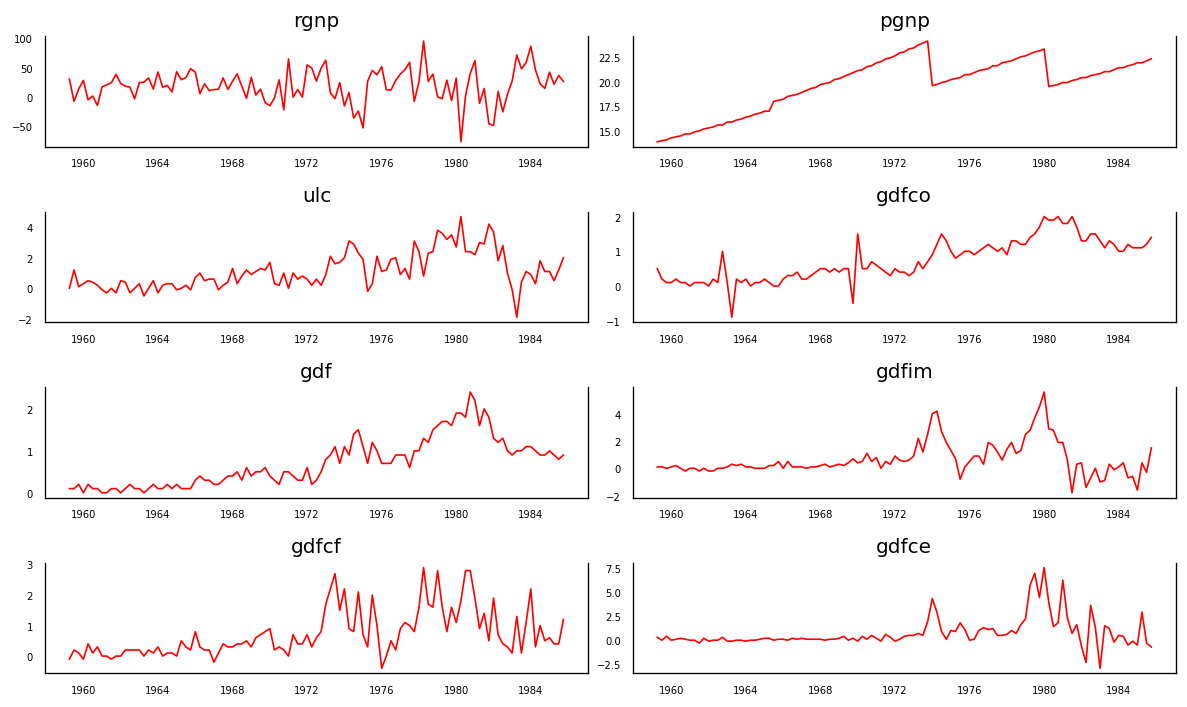

In [65]:
# Plot
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Chequeando si los datos transformados (diferenciados) son estacionarios:

In [66]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(8):
  print('Serie de tiempo transformada', 'Variable',i+1)
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable 1
p-value: 0.000011
Serie de tiempo transformada Variable 2
p-value: 0.296514
Serie de tiempo transformada Variable 3
p-value: 0.036122
Serie de tiempo transformada Variable 4
p-value: 0.609246
Serie de tiempo transformada Variable 5
p-value: 0.348171
Serie de tiempo transformada Variable 6
p-value: 0.102875
Serie de tiempo transformada Variable 7
p-value: 0.190379
Serie de tiempo transformada Variable 8
p-value: 0.251946


La mayoría aún no son estacionarias

In [67]:
#Diferenciando por segunda vez
X_train_transformed=X_train_transformed.diff().dropna()
X_train_transformed.head()

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-07-01,-38.1,0.1,1.2,-3.000000e-01,0.0,0.0,0.3,-0.3
1959-10-01,21.4,0.1,-1.1,-1.000000e-01,0.1,-0.1,-0.1,0.4
1960-01-01,14.3,0.2,0.2,-7.105427e-15,-0.2,0.1,-0.2,-0.4
1960-04-01,-33.0,0.1,0.2,1.000000e-01,0.2,0.1,0.5,0.1
1960-07-01,6.4,0.1,-0.1,-1.000000e-01,-0.1,-0.2,-0.3,0.1


In [68]:
print('Test de Dickey-Fuller Aumentado 3ra vez:')
for i in range(8):
  print('Serie de tiempo transformada', 'Variable',i+1)
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 3ra vez:
Serie de tiempo transformada Variable 1
p-value: 0.000000
Serie de tiempo transformada Variable 2
p-value: 0.000000
Serie de tiempo transformada Variable 3
p-value: 0.000000
Serie de tiempo transformada Variable 4
p-value: 0.000000
Serie de tiempo transformada Variable 5
p-value: 0.001317
Serie de tiempo transformada Variable 6
p-value: 0.000002
Serie de tiempo transformada Variable 7
p-value: 0.006926
Serie de tiempo transformada Variable 8
p-value: 0.003240


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con dos órdenes de diferenciación se obtienen series estacionarias.

# Modelo VAR
VAR requiere la estacionariedad de la serie, lo que significa que la media de la serie no cambia con el tiempo (podemos verlo en el gráfico dibujado junto a la Prueba de Dickey-Fuller aumentada).

In [69]:
model = VAR(X_train_transformed)

## Seleccionando el orden del modelo

In [70]:
modelsel=model.select_order(10)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,-0.8434,-0.6297*,0.4302,-0.7570
1,-1.451,0.4723,0.2354,-0.6735
2,-1.911,1.722,0.1525,-0.4425
3,-2.294,3.048,0.1113,-0.1345
4,-2.743,4.309,0.08133,0.1078
5,-2.597,6.165,0.1190,0.9447
6,-3.797,6.674,0.05231,0.4359
7,-4.818,7.362,0.03394,0.1054
8,-5.749,8.142,0.03329,-0.1339
9,-8.044,7.556,0.01419,-1.738


## Ajustando el modelo

In [71]:
res = model.fit(maxlags=10, ic='aic') 
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Sep, 2023
Time:                     11:56:27
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.97843
Nobs:                     96.0000    HQIC:                  -5.33420
Log likelihood:           150.140    FPE:                 0.00227420
AIC:                     -12.3309    Det(Omega_mle):     1.70299e-05
--------------------------------------------------------------------
Results for equation rgnp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             5.230557         5.586523            0.936           0.349
L1.rgnp          -0.471829         0.399456           -1.181           0.238
L1.pgnp          -5.414112        10.794703           -0.502           0.616


In [72]:
X_train.columns

Index(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'], dtype='object')

# Causalidad de Granger

In [73]:
grangercaus=res.test_causality(['pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['rgnp'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.061,1.408,0.000,"(70, 120)"


In [74]:
grangercaus=res.test_causality(['rgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['pgnp'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.672,1.408,0.000,"(70, 120)"


In [75]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'gdfco', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['ulc'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.179,1.408,0.000,"(70, 120)"


In [76]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['gdfco'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.306,1.408,0.100,"(70, 120)"


gdfco problemática

In [77]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdfim', 'gdfcf', 'gdfce'],['gdf'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
3.491,1.408,0.000,"(70, 120)"


In [78]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfcf', 'gdfce'],['gdfim'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.016,1.408,0.000,"(70, 120)"


In [79]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfce'],['gdfcf'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
4.704,1.408,0.000,"(70, 120)"


In [80]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdfco', 'gdf', 'gdfim', 'gdfcf'],['gdfce'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.926,1.408,0.001,"(70, 120)"


Conclusión: 
gdfco problemática

# Matriz de causalidad de Granger

In [81]:
import warnings
warnings.filterwarnings("ignore")
maxlag=15
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0063,0.0000,0.0014,0.0000,0.0000,0.0000,0.0000
pgnp_y,0.0006,1.0000,0.2375,0.1131,0.0019,0.0011,0.0039,0.0017
ulc_y,0.0000,0.0000,1.0000,0.4204,0.0000,0.0000,0.0000,0.0000
gdfco_y,0.1768,0.0723,0.0012,1.0000,0.0010,0.0000,0.1075,0.0001
gdf_y,0.0001,0.0000,0.0045,0.1834,1.0000,0.0000,0.0249,0.0000
gdfim_y,0.0000,0.0000,0.0000,0.3007,0.0000,1.0000,0.0016,0.0000
gdfcf_y,0.0019,0.0000,0.0284,0.3094,0.0003,0.0001,1.0000,0.0000
gdfce_y,0.0009,0.0022,0.0000,0.3407,0.0000,0.0000,0.0000,1.0000


gdfco no causa la mayoría de las otras variables y tampoco es causada por algunas de ellas.

# Diagnosis del modelo

### Residuos

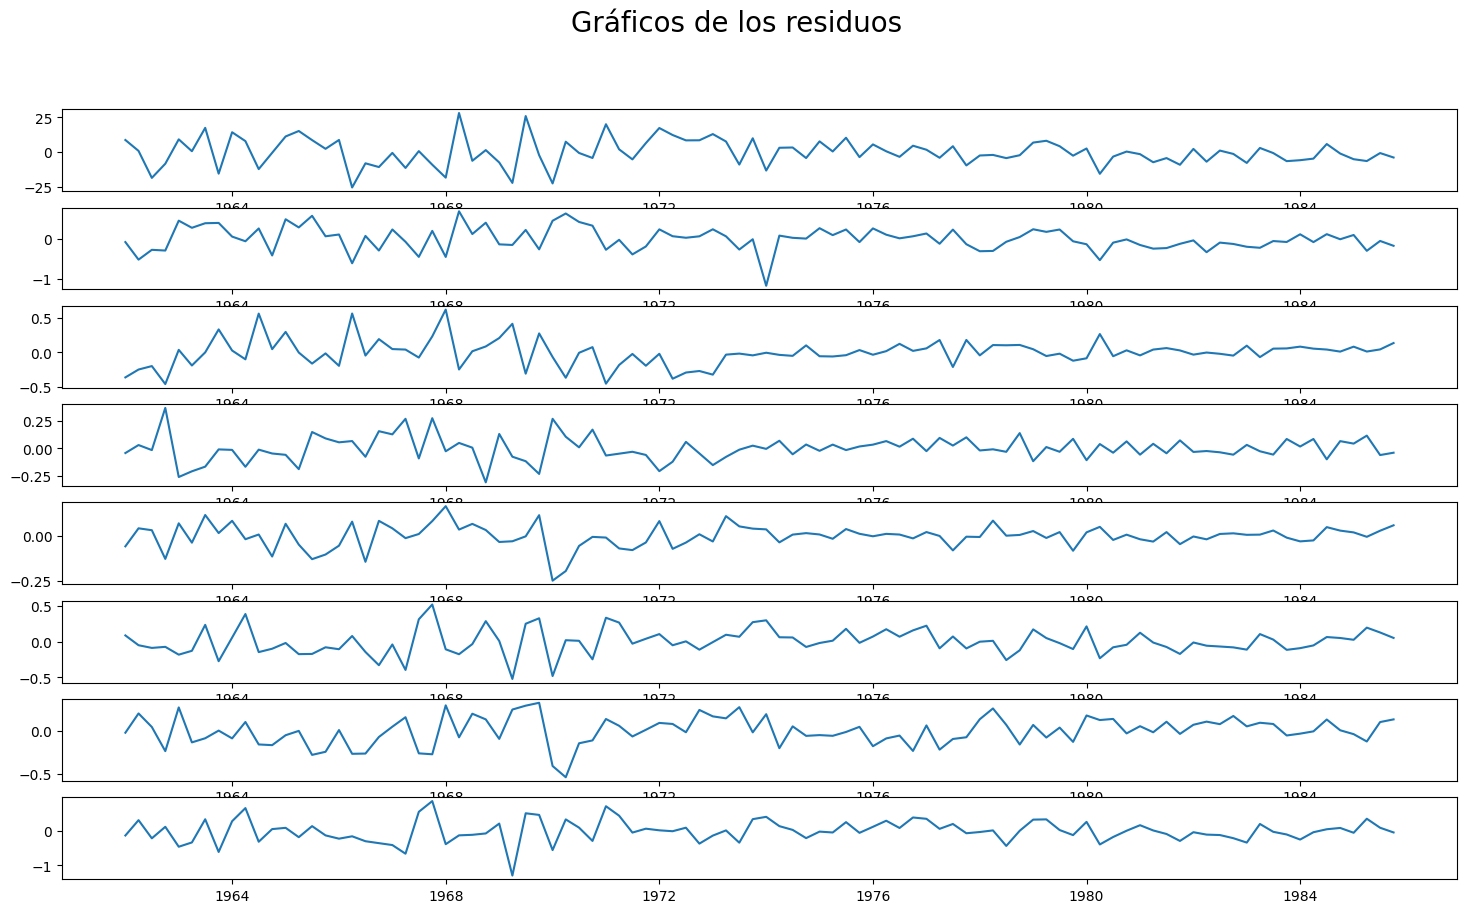

In [82]:
residuals=res.resid

fig, axs = plt.subplots(8)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(8)]
plt.show()

## Dickey - Fuller a los residuos

In [83]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(8)]

ADF de los Residuos, p-valores:


[0.0001023541303206087,
 2.907212319055274e-08,
 0.08978166303073876,
 0.008814113694883026,
 0.0010074442688270838,
 4.3987609350099104e-05,
 2.7460127648796442e-12,
 0.00018227502968195045]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 6 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias. 

## ACF de los Residuos

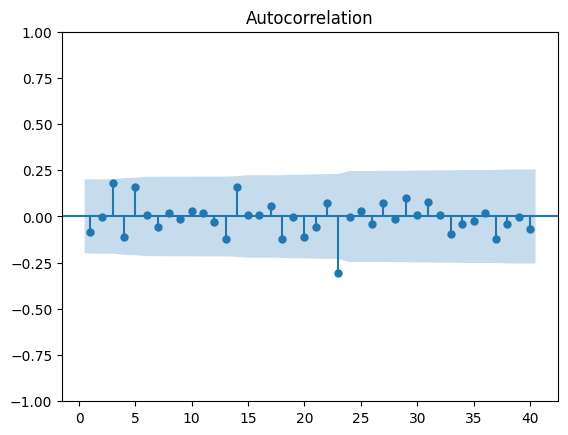

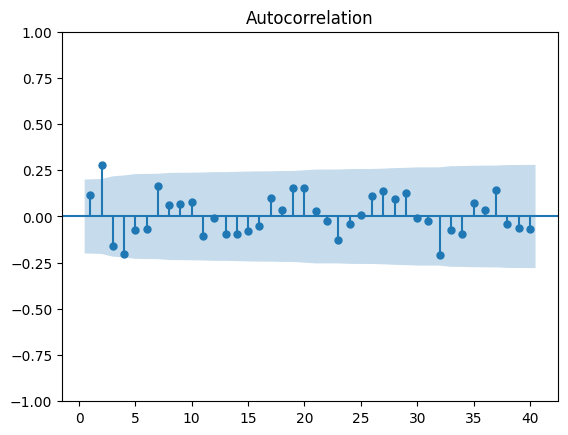

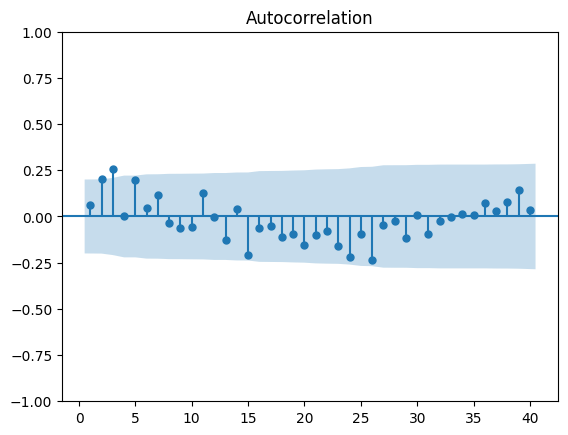

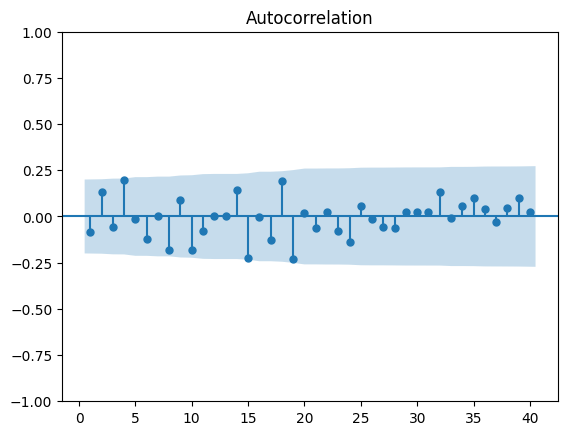

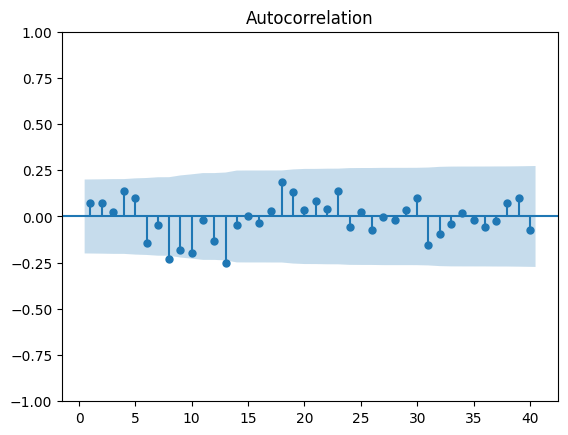

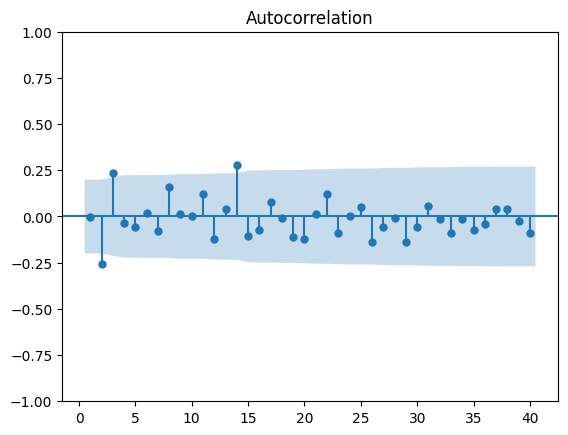

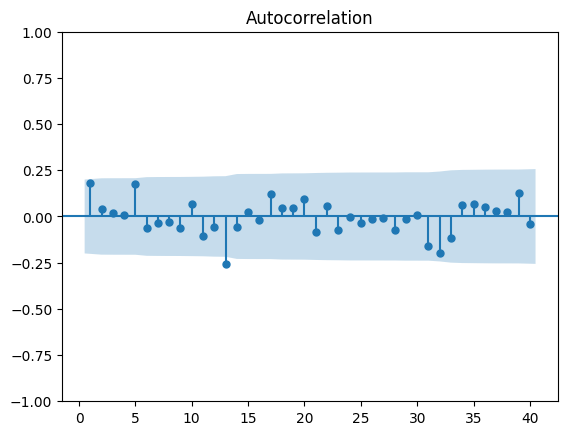

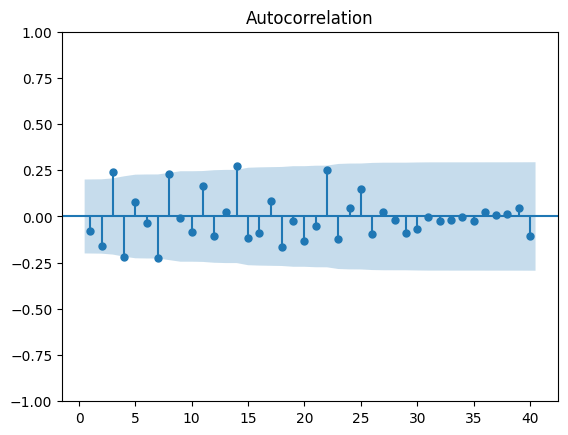

In [84]:
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 40) for i in range(8)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.

## Valores predichos

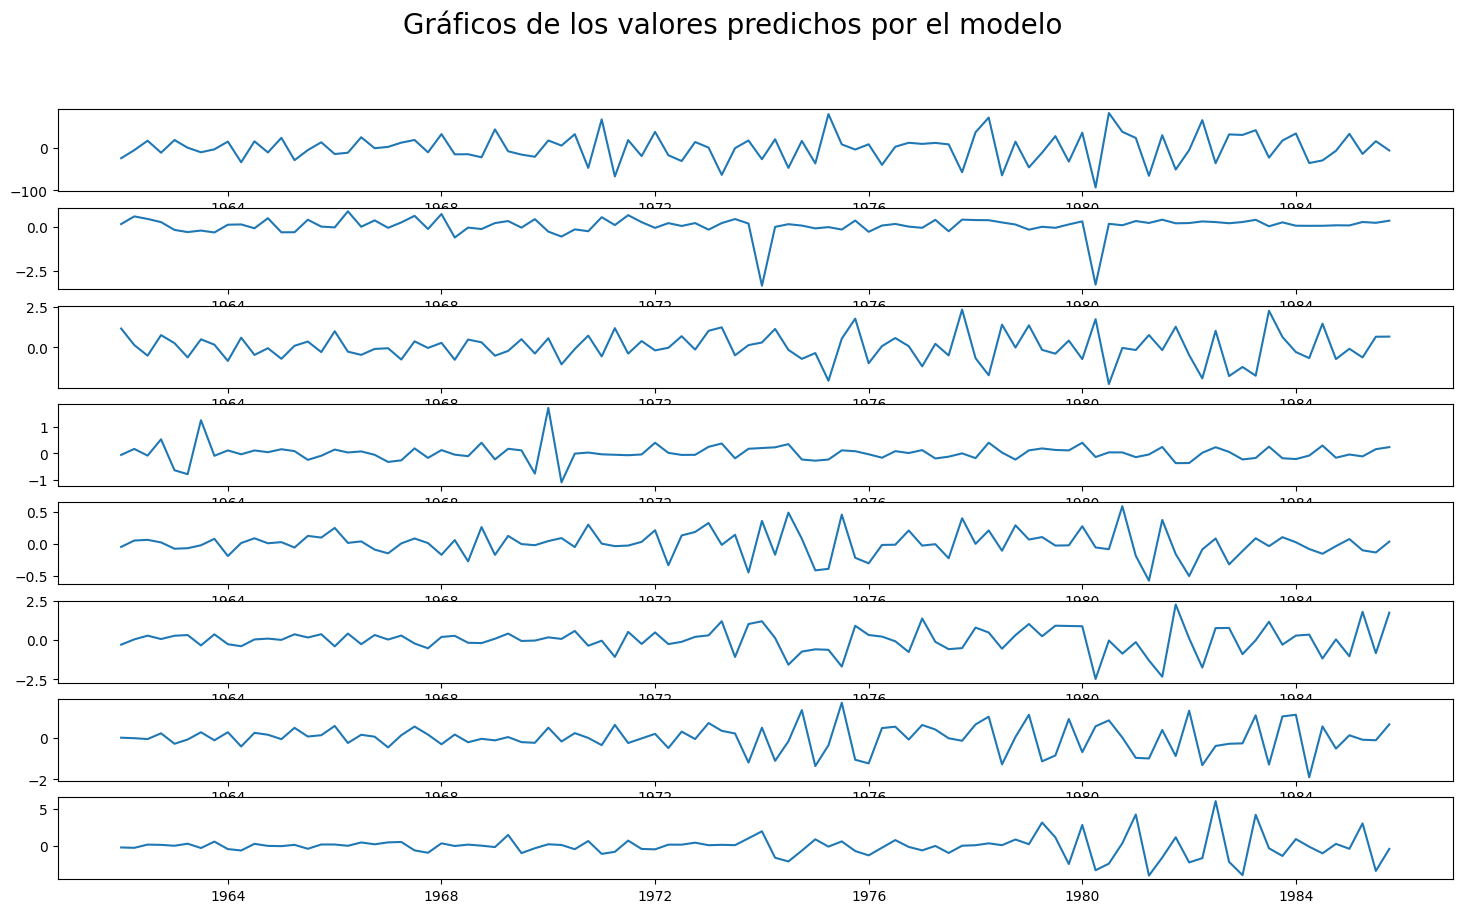

In [85]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(8)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(8)]
plt.show()

# Pronósticos a futuro

### Hallando los pronósticos

Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.


In [86]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=n_obs)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 10
Predicciones:


,rgnp_pred,pgnp_pred,ulc_pred,gdfco_pred,gdf_pred,gdfim_pred,gdfcf_pred,gdfce_pred
date,,,,,,,,
1986-01-01,74.424760,-1.314311,-1.302797,0.681316,0.571579,-0.888824,1.338483,1.235339
1986-04-01,-38.366551,-0.040520,0.742701,-0.543781,-0.417745,0.898785,-0.317722,-1.431937
1986-07-01,-7.494355,-0.961282,1.033408,0.669160,0.809898,0.009719,1.135342,1.860163
1986-10-01,89.032575,2.173991,-0.570721,-0.581789,0.535492,-1.144200,-0.160627,1.209637
1987-01-01,-102.083433,1.111891,1.849864,0.157634,-0.321753,1.825771,-2.441842,3.488823
1987-04-01,-102.438269,-0.812370,0.656942,0.350528,0.192609,-0.059374,1.914837,1.053803
1987-07-01,46.855358,2.028907,0.427207,-0.808868,-0.387618,0.311092,-2.547221,-0.777099
1987-10-01,-25.005739,-2.170229,-0.916368,0.674677,-0.041341,2.456998,0.471148,0.705350
1988-01-01,63.335508,-2.431213,-0.231407,0.263189,0.142386,-0.207809,2.128524,-1.262006


<Figure size 1200x1000 with 0 Axes>

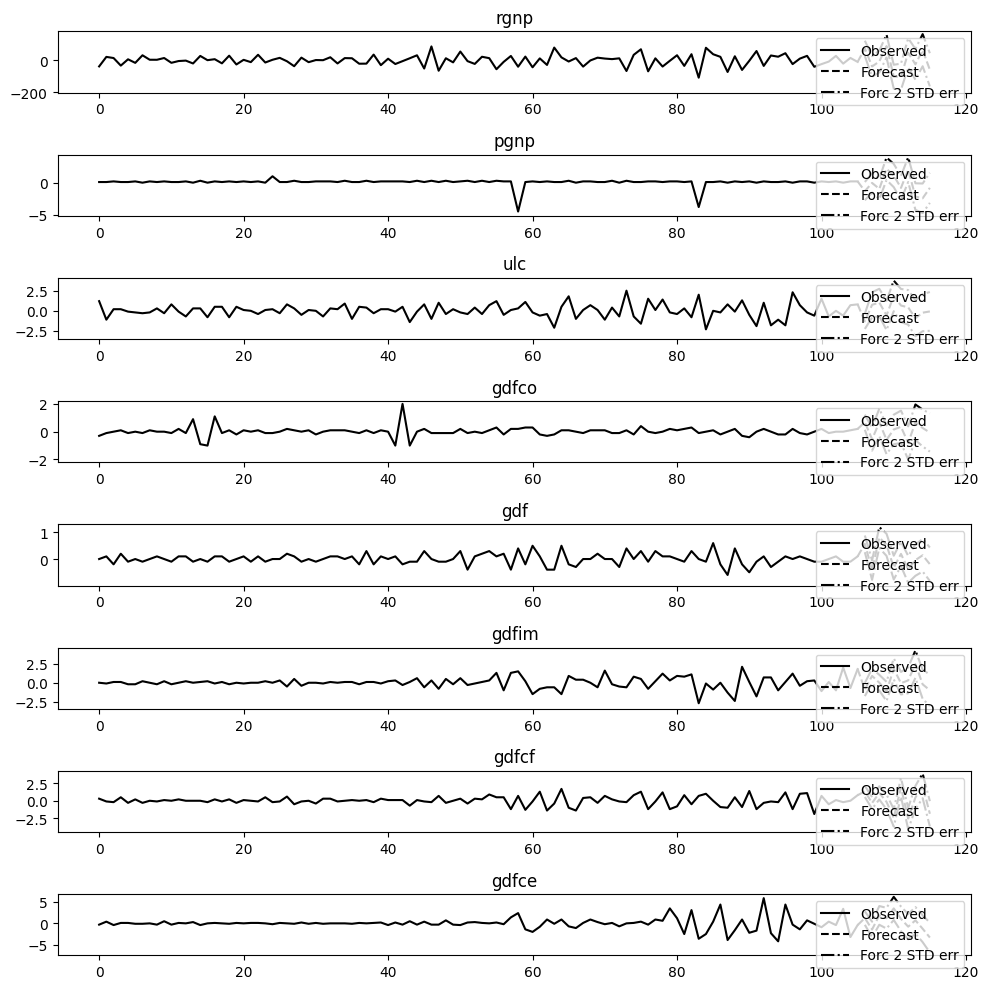

In [87]:
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

## Invirtiendo la transformación de los pronósticos a la escala original

Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos.
La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base.
Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)

In [88]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [89]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1986-01-01,3763.424760,3739.185689,167.797203,118.281316,114.671579,97.411176,112.338483,104.035339
1986-04-01,3826.082969,3760.130858,169.237108,119.818851,115.725412,98.921137,114.559243,103.138741
1986-07-01,3881.246824,3780.114745,171.710421,122.025547,117.589143,100.440817,117.915346,104.102306
1986-10-01,4025.443253,3802.272623,173.613012,123.650453,119.988366,100.816296,121.110821,106.275508
1987-01-01,4067.556250,3825.542392,177.365468,125.432993,122.065837,103.017547,121.864454,111.937533
1987-04-01,4007.230977,3847.999792,181.774866,127.566062,124.335917,105.159424,124.532924,118.653361
1987-07-01,3993.761062,3872.486098,186.611471,128.890263,126.218378,107.612394,124.654172,124.592089
1987-10-01,3955.285408,3894.802175,190.531709,130.889140,128.059499,112.522361,125.246569,131.236168
1988-01-01,3980.145262,3914.687039,194.220540,133.151207,130.043006,117.224520,127.967489,136.618240


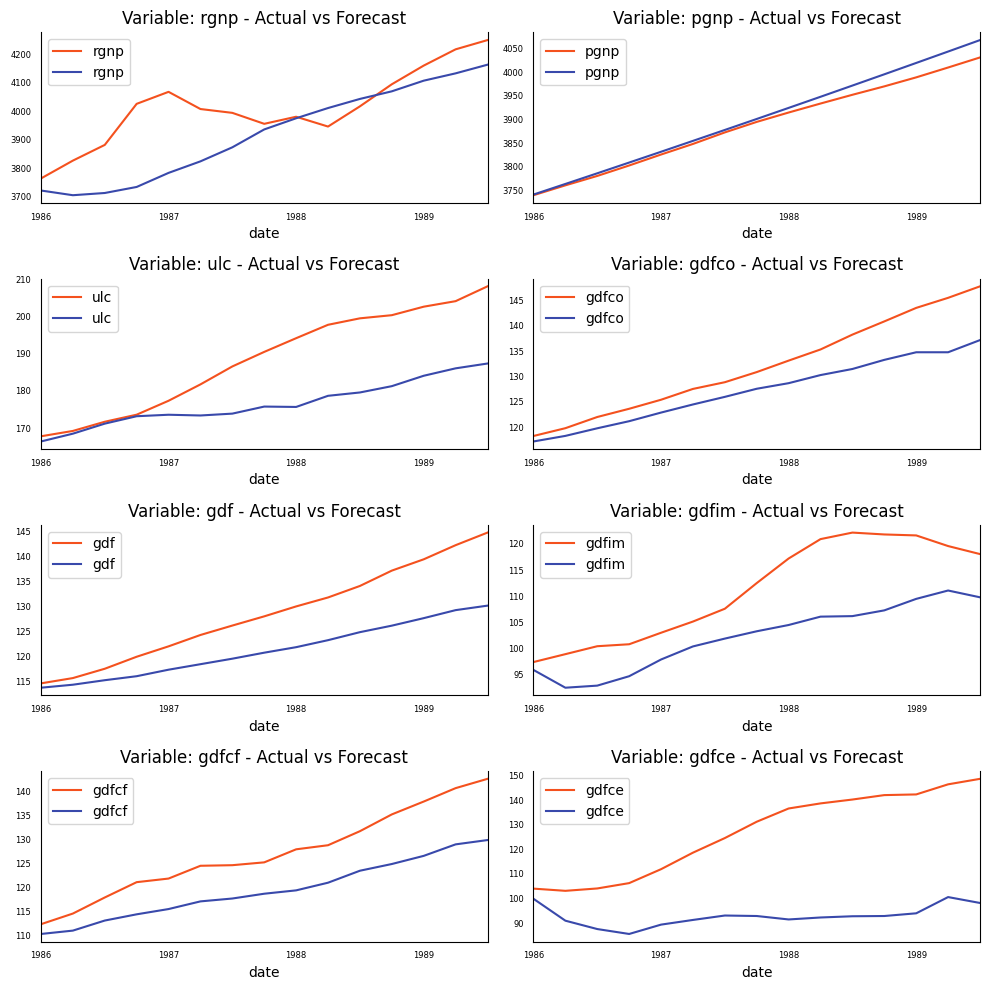

In [90]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

# Evaluando el modelo

In [91]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 24.18615879775586
Root mean squared error: 51.2648909271194


Nota: También se pueden hallar las métricas para cada variable por separado.

# Eliminando la variable gdfco

In [92]:
X_train_transformed_new=X_train_transformed.drop(['gdfco'],axis=1)
X_train_transformed_new.head()

,rgnp,pgnp,ulc,gdf,gdfim,gdfcf,gdfce
date,,,,,,,
1959-07-01,-38.1,0.1,1.2,0.0,0.0,0.3,-0.3
1959-10-01,21.4,0.1,-1.1,0.1,-0.1,-0.1,0.4
1960-01-01,14.3,0.2,0.2,-0.2,0.1,-0.2,-0.4
1960-04-01,-33.0,0.1,0.2,0.2,0.1,0.5,0.1
1960-07-01,6.4,0.1,-0.1,-0.1,-0.2,-0.3,0.1


## Modelo VAR

In [93]:
model_new = VAR(X_train_transformed_new)

In [94]:
modelsel_new=model_new.select_order(10)
modelsel_new.summary()

,AIC,BIC,FPE,HQIC
0,1.303,1.490*,3.680,1.379
1,0.7294,2.225,2.079,1.334
2,0.3198,3.125,1.402,1.453
3,-0.1574,3.956,0.9054,1.505
4,-0.4916,4.931,0.7009,1.700
5,-0.5536,6.178,0.7525,2.167
6,-1.704,6.336,0.2936,1.546
7,-2.261,7.088,0.2303,1.518
8,-3.063,7.595,0.1641,1.245
9,-4.672,7.295,0.06461,0.1650


## Ajustando el modelo

In [95]:
res_new = model_new.fit(maxlags=10, ic='aic')
res_new.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Sep, 2023
Time:                     11:56:38
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    6.55757
Nobs:                     96.0000    HQIC:                  -1.35196
Log likelihood:          -134.050    FPE:                  0.0228544
AIC:                     -6.71827    Det(Omega_mle):     0.000474081
--------------------------------------------------------------------
Results for equation rgnp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             3.859942         4.496644            0.858           0.391
L1.rgnp          -0.727308         0.329755           -2.206           0.027
L1.pgnp          -5.387689         9.726713           -0.554           0.580


## Causalidad de Granger

In [96]:
grangercaus=res_new.test_causality(['pgnp', 'ulc', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['rgnp'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.771,1.395,0.002,"(60, 175)"


In [97]:
grangercaus=res_new.test_causality(['rgnp', 'ulc', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['pgnp'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.203,1.395,0.000,"(60, 175)"


In [98]:
grangercaus=res_new.test_causality(['rgnp', 'pgnp', 'gdf', 'gdfim', 'gdfcf', 'gdfce'],['ulc'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.707,1.395,0.004,"(60, 175)"


In [99]:
grangercaus=res_new.test_causality(['rgnp', 'pgnp', 'ulc', 'gdfim', 'gdfcf', 'gdfce'],['gdf'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.673,1.395,0.005,"(60, 175)"


In [100]:
grangercaus=res.test_causality(['rgnp', 'pgnp', 'ulc', 'gdf', 'gdfcf', 'gdfce'],['gdfim'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.648,1.429,0.011,"(60, 120)"


In [101]:
grangercaus=res_new.test_causality(['rgnp', 'pgnp', 'ulc', 'gdf', 'gdfim', 'gdfce'],['gdfcf'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.548,1.395,0.000,"(60, 175)"


In [102]:
grangercaus=res_new.test_causality(['rgnp', 'pgnp', 'ulc', 'gdf', 'gdfim', 'gdfcf'],['gdfce'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.387,1.395,0.000,"(60, 175)"


In [103]:
warnings.filterwarnings("ignore")
maxlag=10
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: 
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed_new, variables = X_train_transformed_new.columns)

,rgnp_x,pgnp_x,ulc_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0938,0.0000,0.0000,0.0001,0.0000,0.0024
pgnp_y,0.0193,1.0000,0.3597,0.0083,0.0011,0.0400,0.0017
ulc_y,0.0000,0.0412,1.0000,0.0000,0.0000,0.0001,0.0000
gdf_y,0.1357,0.0000,0.0644,1.0000,0.0000,0.3378,0.0000
gdfim_y,0.0111,0.0000,0.0537,0.0000,1.0000,0.0371,0.0000
gdfcf_y,0.0265,0.0000,0.0778,0.0344,0.0018,1.0000,0.0041
gdfce_y,0.0014,0.0158,0.0002,0.0000,0.0117,0.0011,1.0000


## Hallando los pronósticos

In [104]:
X_test_new=X_test.drop(['gdfco'],axis=1)
X_test_new.head()

,rgnp,pgnp,ulc,gdf,gdfim,gdfcf,gdfce
date,,,,,,,
1986-01-01,3721.1,3740.6,166.4,113.8,95.9,110.3,99.9
1986-04-01,3704.6,3763.1,168.5,114.4,92.5,111.0,91.0
1986-07-01,3712.4,3785.7,171.2,115.3,92.9,113.1,87.6
1986-10-01,3733.6,3808.5,173.2,116.1,94.7,114.4,85.6
1987-01-01,3783.0,3831.4,173.6,117.4,97.9,115.5,89.4


In [105]:
# Obtener el orden del modelo
lag_order = res_new.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed_new.values[-lag_order:]
# Forecasting
pred_new = res_new.forecast(y=input_data, steps=n_obs)
pred_new = (pd.DataFrame(pred_new, index=X_test_new.index, columns=X_test_new.columns + '_pred'))
print('Predicciones:')
pred_new

Orden del modelo: 10
Predicciones:


,rgnp_pred,pgnp_pred,ulc_pred,gdf_pred,gdfim_pred,gdfcf_pred,gdfce_pred
date,,,,,,,
1986-01-01,-12.509749,-3.113324,-0.639344,0.390762,-1.268333,1.649990,-4.256077
1986-04-01,14.178140,1.313026,-0.381268,-0.776594,-1.365452,0.030067,-1.403669
1986-07-01,25.549442,-1.398058,-0.921002,1.076135,1.027800,-0.021023,3.610065
1986-10-01,76.532260,1.031374,0.092708,-0.138471,-1.976450,-0.074286,2.640798
1987-01-01,-74.432557,2.828775,1.309070,-0.178758,1.486791,-3.222183,2.502665
1987-04-01,-31.374881,0.451651,-0.189018,0.391736,0.660126,0.978464,2.426958
1987-07-01,-73.334623,1.857201,2.003161,-0.491702,0.832165,-1.090988,0.936265
1987-10-01,1.541812,-2.031808,0.021538,-0.356339,3.971256,0.153495,-2.588640
1988-01-01,64.742531,-3.935308,-2.027292,0.250387,-1.898021,3.086345,-2.927865


## Invirtiendo la transformación de los pronósticos a la escala original

In [106]:
X_train_new=X_train.drop(['gdfco'],axis=1)

In [107]:
pred_new.columns=X_test_new.columns
output = invert_transformation(X_train_new, pred_new, second_diff=True)
output

,rgnp,pgnp,ulc,gdf,gdfim,gdfcf,gdfce
date,,,,,,,
1986-01-01,3676.490251,3737.386676,168.460656,114.490762,97.031667,112.649990,98.543923
1986-04-01,3704.758641,3757.886379,169.440044,115.004929,95.897883,115.530046,92.184178
1986-07-01,3758.576475,3776.988024,169.498430,116.595231,95.791898,118.389080,89.434497
1986-10-01,3888.926568,3797.121043,169.649524,118.047063,93.709463,121.173828,89.325614
1987-01-01,3944.844104,3820.082836,171.109688,119.320136,93.113820,120.736393,91.719396
1987-04-01,3969.386759,3843.496281,172.380834,120.984945,93.178302,121.277422,96.540136
1987-07-01,3920.594791,3868.766926,175.655141,122.158052,94.074949,120.727463,102.297141
1987-10-01,3873.344635,3892.005764,178.950986,122.974820,98.942852,120.330998,105.465505
1988-01-01,3890.837011,3911.309294,180.219539,124.041975,101.912734,123.020879,105.706005


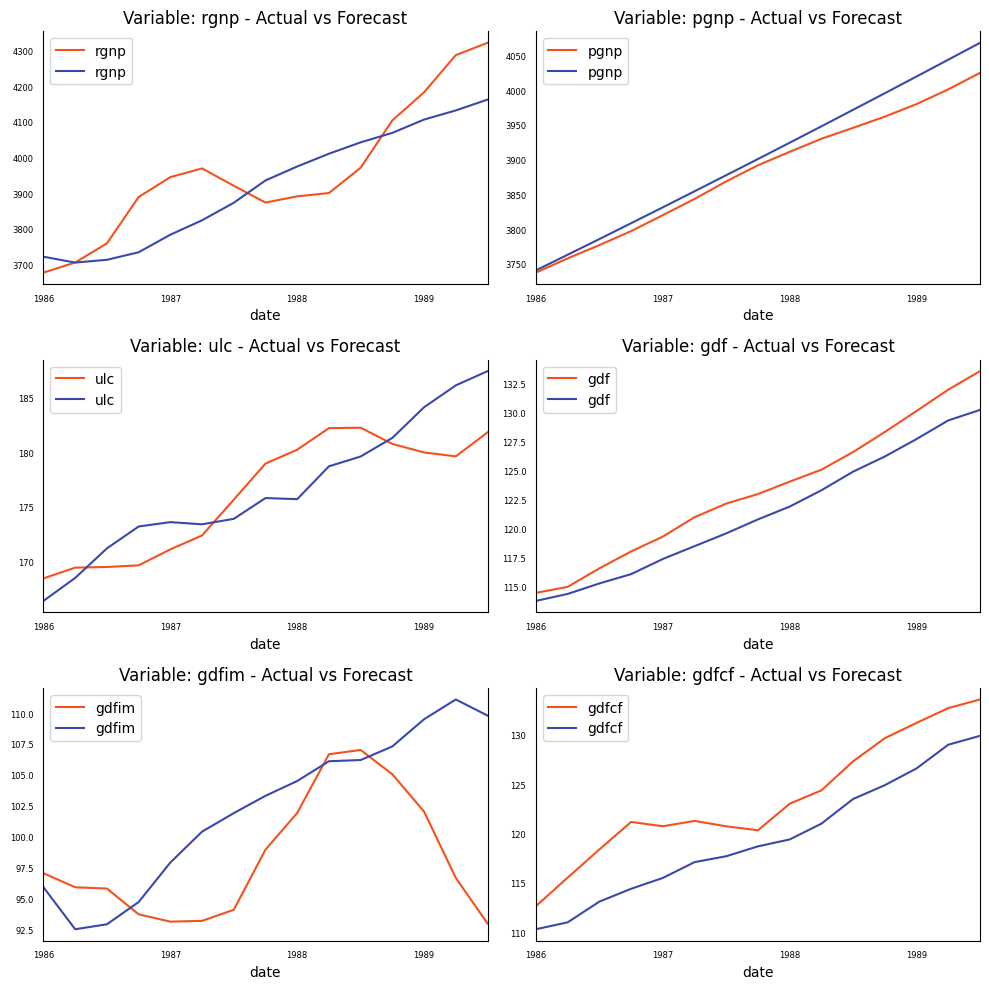

In [108]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train_new.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col,ax) in enumerate(zip(X_train_new.columns, axes.flatten())):
    output[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test_new[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

## Evaluando el modelo

In [109]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test_new, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test_new, output)))

Mean absolute error: 18.537617486948818
Root mean squared error: 40.641947091108726


Conclusión: Los resultados anteriores fueron:

Mean absolute error: 24.1862

Root mean squared error: 51.2649

En este caso ha mejorado el rendimiento del modelo al eliminar una variable redundante: 'gdfco'. 